# Using AutoNormalize with FeatureTools and Compose-ML

In this demo we will use AutoNormalize to create our `entityset` from a mock dataset with a single table. We will use composeml and featuretools to generate labels and features, and then create a machine learning model for predicting one hour in advance whether customers will spend over $1200 within the next hour of transactions.

In [1]:
%matplotlib inline
from featuretools.autonormalize import autonormalize as an
import composeml as cp
import featuretools as ft
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Load Data

In [2]:
transaction_df = ft.demo.load_mock_customer(n_customers=80, n_products=50, n_sessions=200, 
                                n_transactions=10000, return_single_table=True)

transaction_df.head(3)

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth,brand
0,9202,1,2014-01-01 00:00:00,36,81.46,8,desktop,2014-01-01,13244,2013-05-07 20:59:29,1973-07-28,A
1,5776,1,2014-01-01 00:01:05,36,107.59,8,desktop,2014-01-01,13244,2013-05-07 20:59:29,1973-07-28,A
2,1709,1,2014-01-01 00:32:30,36,57.57,8,desktop,2014-01-01,13244,2013-05-07 20:59:29,1973-07-28,A


## Generate Labels

We create our labeling function, and use compose-ml to create our label maker. Using this, we extract our labels. 

In [3]:
def total_spent(df_slice):
    label = df_slice["amount"].sum()
    return label
label_maker = cp.LabelMaker(target_entity='customer_id', time_index='transaction_time', 
                           labeling_function=total_spent, window_size='1h')
labels = label_maker.search(transaction_df, minimum_data='2h', num_examples_per_instance=50, gap='2min')
labels.head(4)

Elapsed: 00:06 | Remaining: 00:00 | Progress: 100%|██████████████████| customer_id: 75/75 


,customer_id,cutoff_time,total_spent
label_id,,,
0,1,2014-01-01 06:30:50,3333.67
1,1,2014-01-03 18:35:10,3131.11
2,1,2014-01-03 18:37:20,3035.19
3,1,2014-01-03 18:39:30,2834.44


We then transform the labels, to have a threshold of $1200, and shift label times an hour earlier for predicting in advance.

In [4]:
labels = labels.threshold(1200)
labels = labels.apply_lead('1h')
labels.head(4)

,customer_id,cutoff_time,total_spent
label_id,,,
0,1,2014-01-01 05:30:50,True
1,1,2014-01-03 17:35:10,True
2,1,2014-01-03 17:37:20,True
3,1,2014-01-03 17:39:30,True


In [5]:
labels.describe()

Label Distribution
------------------
True      1579
False      584
Total:    2163


Settings
--------
num_examples_per_instance      50
minimum_data                   2h
window_size                    1h
gap                          2min


Transforms
----------
1. threshold
  - value:    1200

2. apply_lead
  - value:    1h



## Create an `EntitySet` with AutoNormalize

To create an `EntitySet` with AutoNormalize we just call `auto_entityset()` on our dataframe. AutoNormalize then automatically detects the dependencies within the data, and normalizes the dataframe accordingly. This gives us an automatically normalized entityset!

In [6]:
es = an.auto_entityset(transaction_df, accuracy=1, name="transactions", time_index='transaction_time')
es.add_last_time_indexes()
print(es)

100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


Entityset: transactions
  Entities:
    transaction_id [Rows: 10000, Columns: 5]
    product_id [Rows: 50, Columns: 2]
    session_id [Rows: 200, Columns: 4]
    customer_id [Rows: 75, Columns: 4]
  Relationships:
    transaction_id.session_id -> session_id.session_id
    transaction_id.product_id -> product_id.product_id
    session_id.customer_id -> customer_id.customer_id


It's really that simple. The plot shows you how the library normalized `transaction_df`.

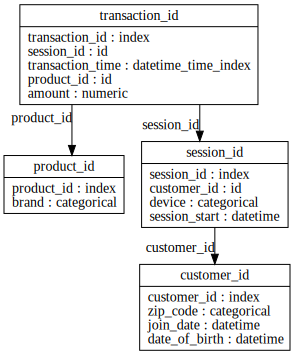

In [10]:
es.plot()

## Create Feature Matrix

Now we generate features using `dfs()`. 

In [11]:
feature_matrix, features_defs = ft.dfs(
    entityset=es,
    target_entity='customer_id',
    cutoff_time=labels,
    cutoff_time_in_index=True,
    verbose=True,
)
features_defs[:20]

Built 73 features
Elapsed: 08:15 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


[<Feature: zip_code>,
 <Feature: COUNT(session_id)>,
 <Feature: NUM_UNIQUE(session_id.device)>,
 <Feature: MODE(session_id.device)>,
 <Feature: SUM(transaction_id.amount)>,
 <Feature: STD(transaction_id.amount)>,
 <Feature: MAX(transaction_id.amount)>,
 <Feature: SKEW(transaction_id.amount)>,
 <Feature: MIN(transaction_id.amount)>,
 <Feature: MEAN(transaction_id.amount)>,
 <Feature: COUNT(transaction_id)>,
 <Feature: NUM_UNIQUE(transaction_id.product_id)>,
 <Feature: MODE(transaction_id.product_id)>,
 <Feature: DAY(join_date)>,
 <Feature: DAY(date_of_birth)>,
 <Feature: YEAR(join_date)>,
 <Feature: YEAR(date_of_birth)>,
 <Feature: MONTH(join_date)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: WEEKDAY(join_date)>]

## Machine Learning

Now we preprocess our features, and split the features and corresponding labels into training and testing sets.

In [12]:
y = feature_matrix.pop(labels.name)
x = feature_matrix.fillna(0)
x, features_enc = ft.encode_features(x, features_defs)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

Now, we train a random forest classifer on the training set, and then test the models performance by evaluating predictions on the testing set.

In [10]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
y_hat = clf.predict(x_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.67      0.06      0.11       129
        True       0.71      0.99      0.83       304

    accuracy                           0.71       433
   macro avg       0.69      0.52      0.47       433
weighted avg       0.70      0.71      0.61       433



This plot is based on scores obtained by the model to illustrate which features are considered important for predictions.

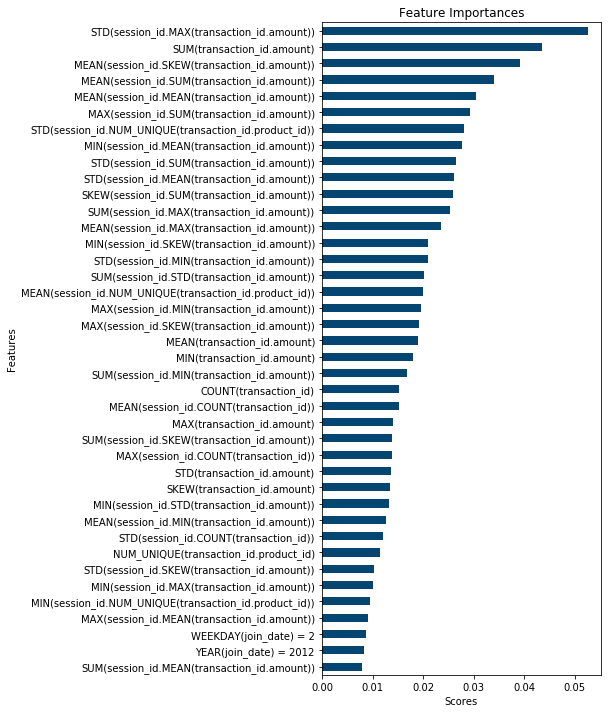

In [14]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(5, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');